In [1]:
import numpy as np

import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))


In [2]:
from sklearn.datasets import make_circles, make_moons, make_gaussian_quantiles, make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Train
X, y = make_moons(n_samples=100, noise=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_test, y_test = make_moons(n_samples=200, noise=0.2, random_state=None)


print("Full training set size (train + val):", X.shape)
print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Full training set size (train + val): (100, 2)
Train set size: (70, 2)
Validation set size: (30, 2)
Test set size: (200, 2)


In [3]:
# np.savez_compressed(
#     "../data/moon_data.npz",
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     X_test=X_test,
#     y_test=y_test
# )

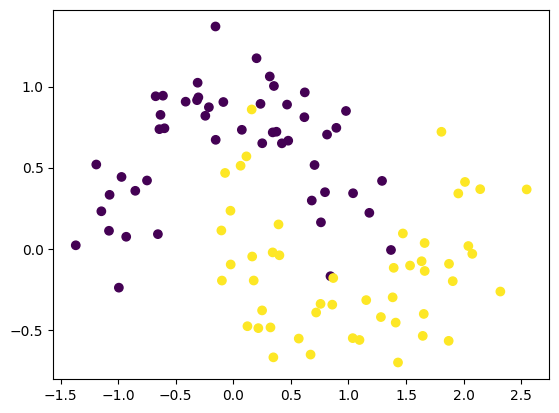

In [4]:
from matplotlib import pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [5]:
import importlib

import src.utils
importlib.reload(src.utils)

<module 'src.utils' from 'd:\\QuantumComputing\\SVQSVM1\\src\\utils.py'>

In [6]:
from sklearn.metrics.pairwise import rbf_kernel
from src.utils import evaluate_model

rbf_K_train = rbf_kernel(X, X)
rbf_K_test = rbf_kernel(X_test, X)

train_acc, test_acc, model, best_c = evaluate_model(rbf_K_train, rbf_K_test, y, y_test)

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Best C parameter: {best_c}")


Training Accuracy: 96.00%
Test Accuracy: 94.00%
Best C parameter: 70.0


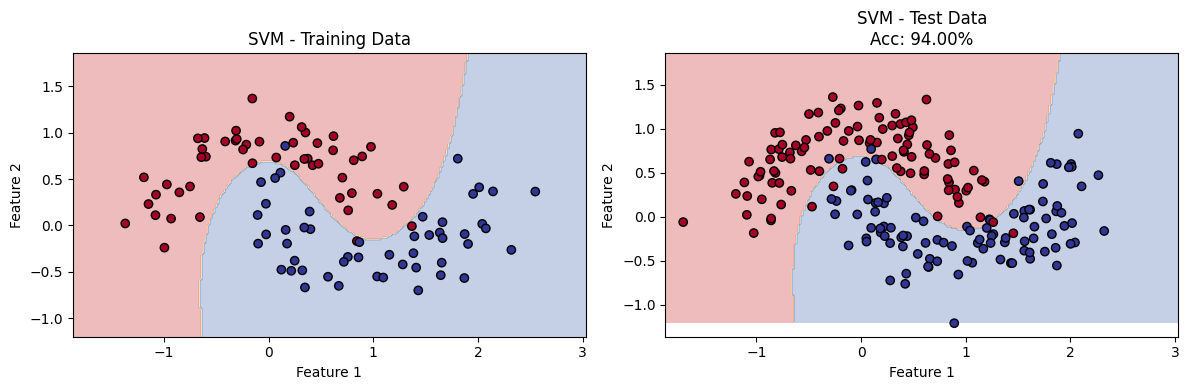

In [7]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
import matplotlib.pyplot as plt

# The model is already trained with precomputed kernel
svm = model

# Create mesh grid for decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# For precomputed kernel, we need to compute kernel between mesh points and training data
mesh_points = np.c_[xx.ravel(), yy.ravel()]
K_mesh = rbf_kernel(mesh_points, X)  # Kernel between mesh and training data

# Predict on mesh grid using the precomputed kernel
Z = svm.predict(K_mesh)
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 4))

# Training data
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')


# Test data
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Test Data\nAcc: {test_acc*100:.2f}%')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [8]:
import importlib

import src.feature_map
importlib.reload(src.feature_map)

<module 'src.feature_map' from 'd:\\QuantumComputing\\SVQSVM1\\src\\feature_map.py'>

In [9]:
from src.feature_map import TrainableQuantumFeatureMap
from src.kernel_estimate import KernelMatrix
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM
import time



# Create optimizer instance based on argument
maxiter = 2000
optimizer_map = {
	"COBYLA": COBYLA(maxiter=maxiter),
	"SPSA": SPSA(maxiter=maxiter, learning_rate=0.05, perturbation=0.01),
	"ADAM": ADAM(maxiter=maxiter, lr= 0.05)
}

optimizer = optimizer_map["COBYLA"]

tqfm = TrainableQuantumFeatureMap(depth=2, type_ansatz="RealAmplitudes", type_loss="hilbert_schmidt")

# Train TQFM
start_time = time.time()
tqfm.fit(X_train, y_train, X_val, y_val, optimizer=optimizer)
training_time = time.time() - start_time

print(f"Optimal value: {tqfm.optimal_value}")
print(f" Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


# Compute kernel matrices
kernel_train_before = KernelMatrix.compute_kernel_matrix_with_inner_products(X, X, tqfm.init_theta, tqfm.circuit)
kernel_train_after_optimal = KernelMatrix.compute_kernel_matrix_with_inner_products(X, X, tqfm.optimal_params, tqfm.circuit)
kernel_train_after_best = KernelMatrix.compute_kernel_matrix_with_inner_products(X, X, tqfm.best_params, tqfm.circuit)
kernel_test = KernelMatrix.compute_kernel_matrix_with_inner_products(X_test, X, tqfm.best_params, tqfm.circuit)


Number of qubits: 2, Number of classes: 2
Optimal value: 0.46672357979733303
 Training completed in 236.32 seconds (3.94 minutes)


In [10]:
from src.utils import evaluate_model

train_acc_b, test_acc_b, _, _ = evaluate_model(kernel_train_before, kernel_test, y, y_test)
train_acc_a_optimal, test_acc_a_optimal, _, _ = evaluate_model(kernel_train_after_optimal, kernel_test, y, y_test)
train_acc_a_best, test_acc_a_best, model, _ = evaluate_model(kernel_train_after_best, kernel_test, y, y_test)

print(f"Train Accuracy before TQFM training: {train_acc_b:.4f}")
print(f"Train Accuracy after TQFM training Optimal: {train_acc_a_optimal:.4f}")
print(f"Train Accuracy after TQFM training Best: {train_acc_a_best:.4f}")
print("="*50)
print(f"Test Accuracy before TQFM training: {test_acc_b:.4f}")
print(f"Test Accuracy after TQFM training Optimal: {test_acc_a_optimal:.4f}")
print(f"Test Accuracy after TQFM training Best: {test_acc_a_best:.4f}")


Train Accuracy before TQFM training: 0.8200
Train Accuracy after TQFM training Optimal: 0.9300
Train Accuracy after TQFM training Best: 0.9500
Test Accuracy before TQFM training: 0.9400
Test Accuracy after TQFM training Optimal: 0.9250
Test Accuracy after TQFM training Best: 0.9400


In [12]:
from src.classifier import QuantumClassifier

qclf = QuantumClassifier()
# Trace Distance
qclf.fit(tqfm.best_rhos_qc_trace, tqfm.circuit, tqfm.best_params_qc_trace)
train_acc_trace = qclf.score(X, y, metric='trace_distance')
test_acc_trace = qclf.score(X_test, y_test, metric='trace_distance')

# Hilbert-S
qclf.fit(tqfm.best_rhos_qc_hs, tqfm.circuit, tqfm.best_params_qc_hs)
train_acc_hs = qclf.score(X, y, metric='hilbert_schmidt')
test_acc_hs = qclf.score(X_test, y_test, metric='hilbert_schmidt')

# Overlap
qclf.fit(tqfm.best_rhos_qc_overlap, tqfm.circuit, tqfm.best_params_qc_overlap)
train_acc_ovl = qclf.score(X, y, metric='overlap')
test_acc_ovl = qclf.score(X_test, y_test, metric='overlap')


print(f"Train Accuracy (Trace Distance): {train_acc_trace:.4f}")
print(f"Test Accuracy (Trace Distance): {train_acc_trace:.4f}")
print("="*50)
print(f"Train Accuracy (Hilbert Schmidt): {train_acc_hs:.4f}")
print(f"Test Accuracy (Hilbert Schmidt): {test_acc_hs:.4f}")
print("="*50)
print(f"Train Accuracy (Overlap): {train_acc_ovl:.4f}")
print(f"Test Accuracy (Overlap): {test_acc_ovl:.4f}")

Train Accuracy (Trace Distance): 0.9500
Test Accuracy (Trace Distance): 0.9500
Train Accuracy (Hilbert Schmidt): 0.9600
Test Accuracy (Hilbert Schmidt): 0.9300
Train Accuracy (Overlap): 0.9500
Test Accuracy (Overlap): 0.9350


In [18]:
import importlib

import src.plotting
importlib.reload(src.plotting)

<module 'src.plotting' from 'd:\\QuantumComputing\\SVQSVM1\\src\\plotting.py'>

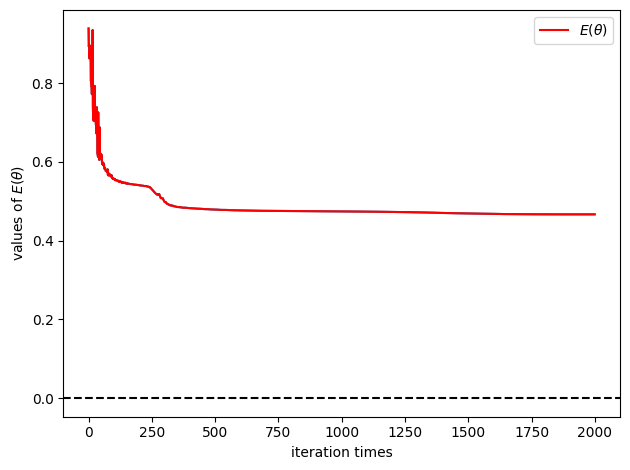

In [19]:
from src.plotting import plot_loss
plot_loss(tqfm)

In [13]:
print("Trace distance:", tqfm.distance[-1])
print("Cross overlap A-B:", tqfm.cross_ovl[-1])

Trace distance: 0.7488235742833071
Cross overlap A-B: 0.21313055710978984


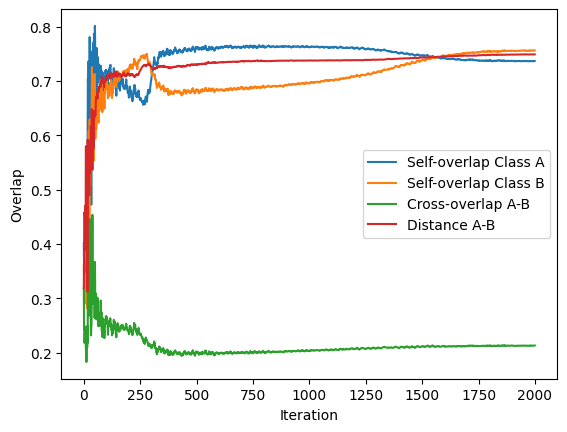

In [14]:
from src.plotting import plot_metrics
plot_metrics(tqfm)

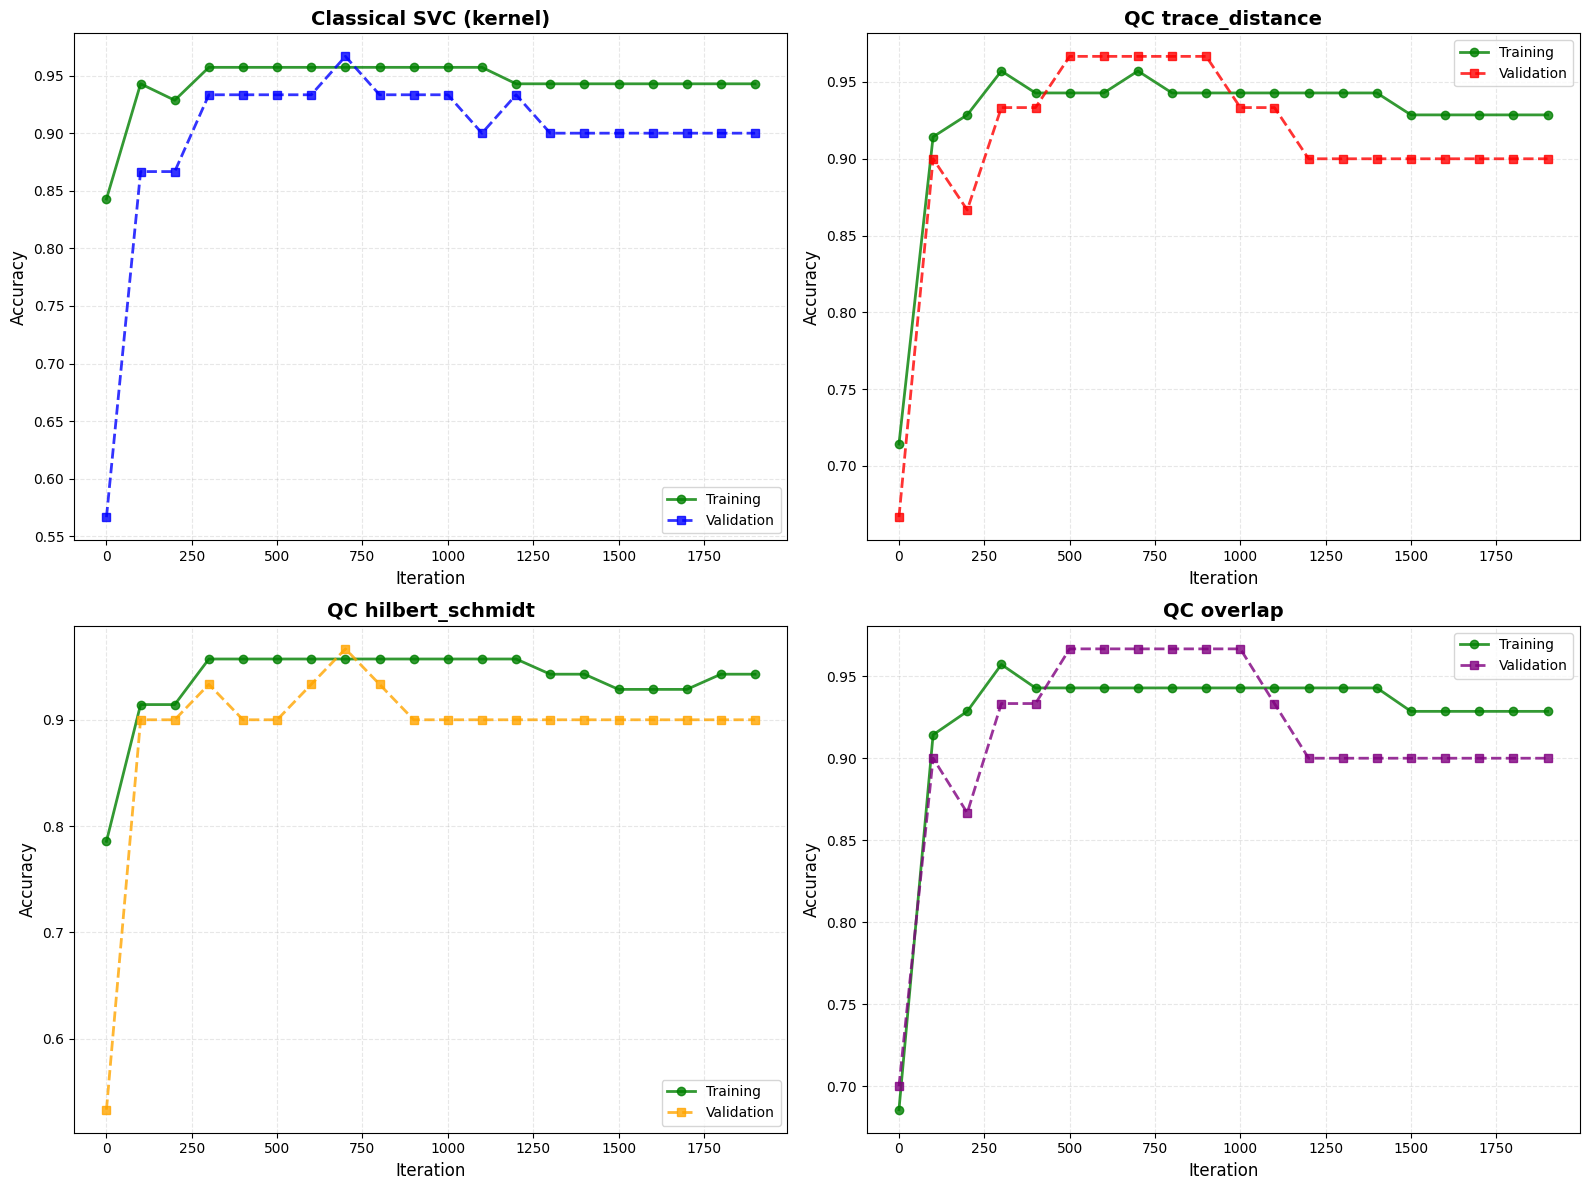

In [15]:
from src.plotting import plot_all_metrics_accuracy
plot_all_metrics_accuracy(tqfm)

In [ ]:
# #Plot loss landscape for all parameters
# num_params = len(tqfm.optimal_params)
# for i in range(num_params):
# 	tqfm.plot_loss_landscape_1d(param_idx=i, grid_points=50, param_range=3*np.pi)

Computing loss landscape (50x50 grid)...


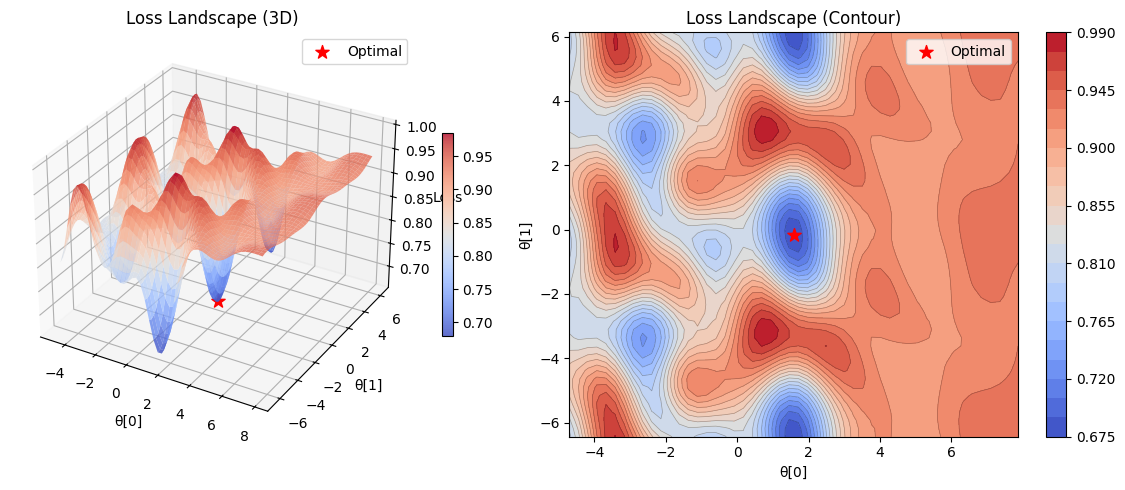

In [ ]:
# from src.plotting import plot_landscape_2d
# plot_landscape_2d(tqfm, param_idx1=0, param_idx2=1, param_range=2*np.pi, grid_points=50)

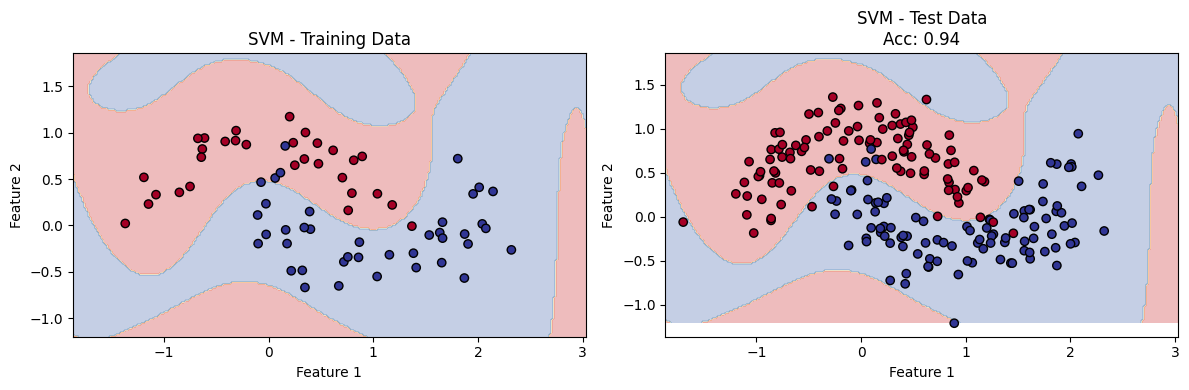

In [16]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# The model is already trained with precomputed kernel
svm = model

# Create mesh grid for decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# For precomputed kernel, we need to compute kernel between mesh points and training data
mesh_points = np.c_[xx.ravel(), yy.ravel()]
K_mesh = KernelMatrix.compute_kernel_matrix_with_inner_products(mesh_points, X, tqfm.best_params, tqfm.circuit)

# Predict on mesh grid using the precomputed kernel
Z = svm.predict(K_mesh)
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 4))

# Training data
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')


# Test data
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Test Data\nAcc: {test_acc_a_best:.2f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()